In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib

import functions_ai

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1) Setup 

In [3]:
metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')] #verschillende metrics vergelijken

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

## 2) Build initial model

In [4]:
custom_preprocessing = functions_ai.custom_preprocessing
batch_size = 128
img_height = img_width = 128

#set the paths/directories
path = pathlib.Path('covid xray')
train_dir = os.path.join(path, 'train') 
validation_dir = os.path.join(path, 'val')
test_dir = os.path.join(path, 'test')

train_covid_dir = os.path.join(train_dir, 'COVID')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

validation_covid_dir = os.path.join(validation_dir, 'COVID')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

test_covid_dir = os.path.join(test_dir, 'COVID')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

#print(train_dir)

In [5]:
def custom_preprocessing(img): #implemntation in ImageDataGenerator 
    return (img - mean) / std

#### In task 2 we use image_dataset_from_directory instead of ImageDataGenerator, so datasets can be concatenated

In [6]:
# Load training dataset
train_data_gen = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

# Load validation dataset
val_data_gen = tf.keras.utils.image_dataset_from_directory(
    directory=validation_dir,
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

# Load test dataset
test_data_gen = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)


Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [7]:
mean, std = 0.11728907, 0.3424749
def custom_preprocessing(image):
   return (image - mean) / std

In [8]:
train_data_gen = train_data_gen.map(lambda x, y: (custom_preprocessing(x), y))
val_data_gen = val_data_gen.map(lambda x, y: (custom_preprocessing(x), y))
test_data_gen = test_data_gen.map(lambda x, y: (custom_preprocessing(x), y))

In [9]:
rescale = Rescaling(1 / 255)

In [11]:
def preprocess_image(transform):
    
    def _preprocess(image, label):
        return transform(image), label
        
    return _preprocess

In [12]:
train_data_preproc = train_data_gen.map(preprocess_image(rescale))
val_data_preproc = val_data_gen.map(preprocess_image(rescale))

In [13]:
train_data_preproc = train_data_preproc.cache()
val_data_preproc = val_data_preproc.cache()

### Defining the model

In [14]:
#augmentation:
flip =  RandomFlip("horizontal")
rotate = RandomRotation((-0.125, 0.125))
translate = RandomTranslation(height_factor=0.15, width_factor=0.15)
zoom = RandomZoom(0.5)

In [15]:
#model with dropout and augmentation 
model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    flip,
    rotate, 
    translate,
    zoom,
    Conv2D(16, 3, padding='same', activation='relu'), 
    
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.1), 
    
    Conv2D(32, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    
    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.2), #somewhat more severe dropout
    
    Flatten(),
    Dense(512, activation='relu'), #in dense layers dropout of 0.5, in general more dropout at end bcs more prone to overfitting (more abstract features learned at end)
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 128, 128, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,413,665 (32.10 MB)

 Trainable params: 8,413,441 (32.09 MB)

 Non-trainable params: 224 (896.00 B)

## 3) Train your model

In [18]:
#choose loss function binary cross entropy
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
adam = Adam(learning_rate=learning_rate)

model.compile(
    optimizer=adam,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics
)


In [ ]:
history = model.fit(
    train_data_preproc,
    validation_data=val_data_preproc, 
    epochs=30,
    verbose = 1
)

Epoch 1/30
 2/13 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8066 - auc: 0.8958 - loss: 0.4115 - precision: 0.8667 - recall: 0.7472

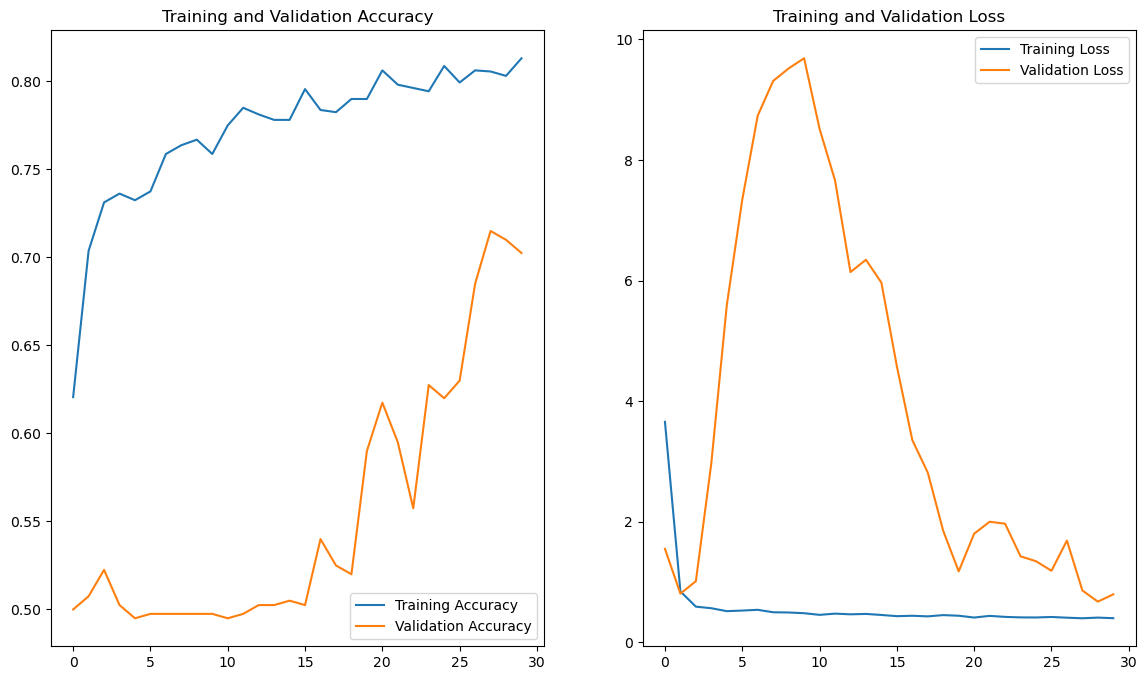

In [22]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


## 4) Hyperparameter tuning

### Implement early stopping

### parameter search to tune your model

In [23]:
def build_model(optimizer,filters=(16, 32, 64), dropout1=0.1, dropout2=0.2, dropout3=0.5, learning_rate=0.001):
    model = Sequential([
        Input(shape=(img_height, img_width, 3)),
        flip,
        rotate, 
        translate,
        zoom,
        Conv2D(16, 3, padding='same', activation='relu'), #remark: still debate over ReLu -> BN (theoretical) / BN -> ReLu (in practice) [both used]
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.1), #dont 'kill' important features (in beginning most low levels features are learned)
        
        Conv2D(32, 3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        
        Conv2D(64, 3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2), #somewhat more severe dropout
        
        Flatten(),
        Dense(512, activation='relu'), #in dense layers dropout of 0.5, in general more dropout at end bcs more prone to overfitting (more abstract features learned at end)
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # optimizer
    if opt == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif opt == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)


    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model


### NU MOETEN WE VALIDATIESET EN TRAINING SET OPTELLEN BIJ ELKAAR EN DA ALS 1 SET GEBRUIKEN ALS TRAINING SET EN DAN OP TEST SET HET CONTROLEREN

In [ ]:
import itertools
import pandas as pd

# Define hyperparameter ranges
dropout1_list = [0.1, 0.3]
dropout2_list = [0.2, 0.4]
learning_rates = [0.001, 0.0005]
filters_list = [(16, 32, 64), (8, 16, 32)]
optimizers = ['adam', 'rmsprop']

# To store results
results = []

# Loop over all combinations
for d1, d2, lr, opt, filt in itertools.product(dropout1_list, dropout2_list, learning_rates, optimizers, filters_list):
    print(f"\nTraining with d1={d1}, d2={d2}, lr={lr}, opt={opt}, filters={filt}")
    
    model = build_model(
        opt,
        filters=filt,
        dropout1=d1,
        dropout2=d2,
        dropout3=0.5,
        learning_rate=lr
    )

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        train_data_gen_aug,
        validation_data=val_data_gen 
        epochs=30,
        batch_size= batch_size,
        callbacks=[early_stop],
        verbose=1)

    # Save last epoch metrics
    last_epoch = -1
    results.append({
    'dropout1': d1,
    'dropout2': d2,
    'dropout3': 0.5,
    'learning_rate': lr,
    'batch_size': batch_size,
    'filters': filt,
    'optimizer': opt, 
    'val_accuracy': history.history['val_accuracy'][last_epoch],
    'val_precision': history.history['val_precision'][last_epoch],
    'val_recall': history.history['val_recall'][last_epoch],
    'val_auc': history.history['val_auc'][last_epoch]
})


# Save to CSV
df = pd.DataFrame(results)
df.to_csv("grid_search_hyperparams_results2.0.csv", index=False)


## 5) final baseline model (with validation set) 

In [ ]:
model_final = build_model(
        'adam',
        filters=(8, 16, 32),
        dropout1=0.1,
        dropout2=0.2,
        dropout3=0.5,
        learning_rate= 0.0005
    )


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_final = model_final.fit(
        train_data_gen_aug,
        validation_data=val_data_gen, #including validation dataset 
        epochs=30,
        batch_size= batch_size,
        callbacks=[early_stop],
        verbose=1)

In [ ]:
# List of metrics to plot
metrics_to_plot = ['accuracy', 'precision', 'recall', 'auc']

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i + 1)
    plt.plot(history_final.history[metric], label=f'Train {metric}')
    #plt.plot(history_final.history[f'val_{metric}'], label=f'Val {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
model_final.save("final_model.h5")
baselinemodel = load_model("final_model.h5")

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_data = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size
).map(lambda x, y: (custom_preprocessing(x), y))

true_labels = []
predicted_labels = []

for images, labels in test_data:
    predictions = (baselinemodel.predict(images) > 0.5).astype("int32").flatten()
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predictions)

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(